In [1]:
!pip install segmentation-models-pytorch

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import InterpolationMode
from scipy.ndimage import binary_erosion, distance_transform_edt
from torchvision.models import resnet50, ResNet50_Weights
import segmentation_models_pytorch as smp
from tqdm import tqdm

import os
save_dir = "/content/drive/MyDrive/SHBT261/Project2"
os.makedirs(save_dir, exist_ok=True)

In [4]:
# Define the 21 classes
VOC_CLASSES = [
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus",
    "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike",
    "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
NUM_CLASSES = len(VOC_CLASSES)
print("Number of classes:", NUM_CLASSES)
print("Classes:", VOC_CLASSES)

# Class mapping dictionary
class_mapping = {i: cls for i, cls in enumerate(VOC_CLASSES)}

print("Pascal VOC 2007 Class Mapping:")
for idx, name in class_mapping.items():
    print(f"{idx:2d} → {name}")

Number of classes: 21
Classes: ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
Pascal VOC 2007 Class Mapping:
 0 → background
 1 → aeroplane
 2 → bicycle
 3 → bird
 4 → boat
 5 → bottle
 6 → bus
 7 → car
 8 → cat
 9 → chair
10 → cow
11 → diningtable
12 → dog
13 → horse
14 → motorbike
15 → person
16 → pottedplant
17 → sheep
18 → sofa
19 → train
20 → tvmonitor


In [ ]:
# Define transforms for the images
transform_img = transforms.Compose([
    transforms.Resize((256, 256)),           # resize for speed
    # ---------------------------------------
    # Data Augmentation
    # ---------------------------------------
    # transforms.ColorJitter(
    #     brightness=0.3,
    #     contrast=0.3,
    #     saturation=0.3,
    #     hue=0.02
    # ),
    # transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),                   # convert to tensor (C,H,W)
])

transform_target = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.NEAREST),
    # transforms.Resize((256, 256)),           # resize mask too
    transforms.PILToTensor()                 # keep as tensor (H,W)
])

# Load the Pascal VOC 2007 Segmentation Dataset
train_dataset = VOCSegmentation(
    root="/content/drive/MyDrive/SHBT261/Project2/VOCtrainval_06-Nov-2007",
    year="2007",
    image_set="train",
    download=False,
    transform=transform_img,
    target_transform=transform_target
)

val_dataset = VOCSegmentation(
    root="/content/drive/MyDrive/SHBT261/Project2/VOCtrainval_06-Nov-2007",
    year="2007",
    image_set="val",
    download=False,
    transform=transform_img,
    target_transform=transform_target
)

print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))

Train samples: 209
Validation samples: 213


In [6]:
# Create DataLoaders
train_size = int(0.8 * len(train_dataset))
train_val_size = len(train_dataset) - train_size

train_set, train_val_set = random_split(train_dataset, [train_size, train_val_size])

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
train_val_loader = DataLoader(train_val_set, batch_size=4, shuffle=False, num_workers=2)

test_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])


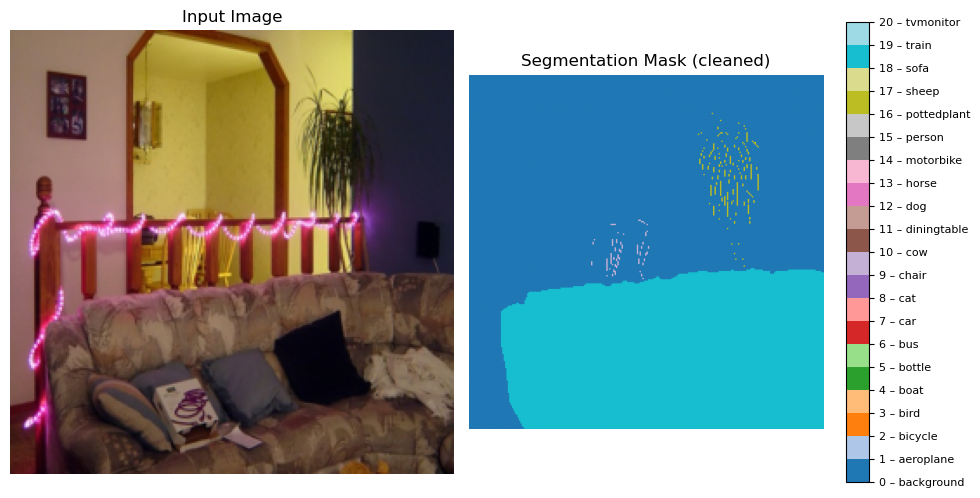

Classes in this mask: [  0   9  16  18 255]


In [7]:
# Visualize one image and mask
def show_sample(img, mask):
    img = img.permute(1, 2, 0).numpy()      # C,H,W -> H,W,C
    mask = mask.squeeze().numpy().copy()    # 1,H,W -> H,W

    mask_vis = mask.copy()
    mask_vis[mask_vis > 20] = 0

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    seg_map = plt.imshow(mask_vis, cmap="tab20", vmin=0, vmax=20)
    plt.title("Segmentation Mask (cleaned)")
    plt.axis("off")

    cbar = plt.colorbar(seg_map, ticks=range(21))
    tick_labels = [f"{i} – {VOC_CLASSES[i]}" for i in range(21)]
    cbar.ax.set_yticklabels(tick_labels)
    cbar.ax.tick_params(labelsize=8)
    plt.tight_layout()
    plt.show()

images, masks = next(iter(train_loader))
print("Image batch shape:", images.shape)    # (B, 3, 256, 256)
print("Mask batch shape:", masks.shape)      # (B, 1, 256, 256)
show_sample(images[0], masks[0])
print("Classes in this mask:", np.unique(masks[0].numpy()))

### Model

In [8]:
IGNORE_INDEX = 255

def update_confusion_matrix(conf_mat, preds, targets, num_classes, ignore_index=IGNORE_INDEX):
    with torch.no_grad():
        valid_mask = (targets != ignore_index)
        preds = preds[valid_mask]
        targets = targets[valid_mask]
        if preds.numel() == 0:
            return

        k = (targets * num_classes + preds).long()
        bins = torch.bincount(k, minlength=num_classes * num_classes)
        conf = bins.reshape(num_classes, num_classes)
        conf_mat += conf.to(conf_mat.device)

def compute_metrics_from_confusion(conf_mat: np.ndarray):
    C = conf_mat.shape[0]
    conf = conf_mat.astype(np.float64)

    TP = np.diag(conf)
    FP = conf.sum(axis=0) - TP
    FN = conf.sum(axis=1) - TP

    # IoU per class
    denom_iou = TP + FP + FN
    per_class_iou = np.zeros(C, dtype=np.float64)
    per_class_iou[denom_iou > 0] = TP[denom_iou > 0] / denom_iou[denom_iou > 0]

    # Dice per class
    denom_dice = 2 * TP + FP + FN
    per_class_dice = np.zeros(C, dtype=np.float64)
    per_class_dice[denom_dice > 0] = 2 * TP[denom_dice > 0] / denom_dice[denom_dice > 0]

    # Per-class accuracy
    gt_per_class = conf.sum(axis=1)
    per_class_acc = np.zeros(C, dtype=np.float64)
    per_class_acc[gt_per_class > 0] = TP[gt_per_class > 0] / gt_per_class[gt_per_class > 0]

    # Pixel accuracy
    pixel_acc = TP.sum() / conf.sum() if conf.sum() > 0 else 0.0

    # 有 GT 像素的类别才参与平均
    valid_classes = gt_per_class > 0
    mean_iou = per_class_iou[valid_classes].mean() if valid_classes.any() else 0.0
    mean_dice = per_class_dice[valid_classes].mean() if valid_classes.any() else 0.0

    return {
        "pixel_acc": float(pixel_acc),
        "mean_iou": float(mean_iou),
        "mean_dice": float(mean_dice),
        "per_class_iou": per_class_iou,
        "per_class_acc": per_class_acc,
        "per_class_dice": per_class_dice,
    }

def hd95_binary(pred_mask: np.ndarray, true_mask: np.ndarray) -> float:
    pred = pred_mask.astype(bool)
    true = true_mask.astype(bool)

    if not pred.any() and not true.any():
        return 0.0

    if not pred.any() or not true.any():
        return 255.0

    structure = np.ones((3, 3), dtype=bool)
    true_erode = binary_erosion(true, structure=structure, border_value=0)
    pred_erode = binary_erosion(pred, structure=structure, border_value=0)

    true_surface = true ^ true_erode
    pred_surface = pred ^ pred_erode

    dt_true = distance_transform_edt(~true)
    dt_pred = distance_transform_edt(~pred)

    dist_true_to_pred = dt_pred[true_surface]
    dist_pred_to_true = dt_true[pred_surface]

    all_dist = np.concatenate([dist_true_to_pred, dist_pred_to_true])
    hd95 = np.percentile(all_dist, 95)

    return float(hd95)

In [ ]:
# ---------------------------------------
# Stable Multi-class Soft Dice Loss
# ---------------------------------------
class DiceLoss(nn.Module):
    def __init__(self, num_classes=21, ignore_index=255, smooth=1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        B, C, H, W = probs.shape

        valid = (targets != self.ignore_index)
        targets_clean = targets.clone()
        targets_clean[~valid] = 0  # dummy class

        # (B,H,W,C) -> (B,C,H,W)
        targets_onehot = F.one_hot(targets_clean, C).permute(0,3,1,2).float()

        probs = probs * valid.unsqueeze(1)
        targets_onehot = targets_onehot * valid.unsqueeze(1)

        # flatten
        probs_flat   = probs.reshape(B, C, -1)
        targets_flat = targets_onehot.reshape(B, C, -1)

        intersection = (probs_flat * targets_flat).sum(-1)
        union = probs_flat.sum(-1) + targets_flat.sum(-1)

        dice = (2 * intersection + self.smooth) / (union + self.smooth)

        # remove background
        dice_fg = dice[:, 1:]

        # keep only GT-present classes
        exist_mask = (targets_flat[:, 1:].sum(-1) > 0)
        dice_fg = dice_fg[exist_mask]

        if dice_fg.numel() == 0:
            return torch.tensor(0.0, device=logits.device)

        return 1 - dice_fg.mean()

### training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
).to(device)

criterion_ce = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
criterion_dice = DiceLoss(num_classes=NUM_CLASSES)

def criterion(pred, target):
    ce   = criterion_ce(pred, target)
    dice = criterion_dice(pred, target)
    return ce + 0.02 * dice

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 254MB/s]


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    n_samples = 0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device).squeeze(1).long()  # (B,1,H,W)->(B,H,W)

        optimizer.zero_grad()
        outputs = model(images)  # (B,C,H,W)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        bs = images.size(0)
        running_loss += loss.item() * bs
        n_samples += bs

    return running_loss / n_samples

def evaluate(model, loader, criterion, device, num_classes):
    model.eval()
    val_loss = 0.0
    n_samples = 0
    conf_mat = torch.zeros((num_classes, num_classes), dtype=torch.long)

    hd95_list = []

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device).squeeze(1).long()

            outputs = model(images)  # (B,C,H,W)
            loss = criterion(outputs, masks)

            bs = images.size(0)
            val_loss += loss.item() * bs
            n_samples += bs

            preds = outputs.argmax(dim=1)  # (B,H,W)

            update_confusion_matrix(
                conf_mat,
                preds.view(-1).cpu(),
                masks.view(-1).cpu(),
                num_classes=num_classes,
                ignore_index=IGNORE_INDEX
            )

            preds_np = preds.cpu().numpy()
            masks_np = masks.cpu().numpy()

            for i in range(bs):
                gt = masks_np[i]
                pr = preds_np[i]

                gt_fg = (gt != 0) & (gt != IGNORE_INDEX)
                pr_fg = (pr != 0)

                if not gt_fg.any() and not pr_fg.any():
                    continue

                hd = hd95_binary(pr_fg, gt_fg)
                hd95_list.append(hd)

    avg_loss = val_loss / n_samples
    metrics = compute_metrics_from_confusion(conf_mat.cpu().numpy())
    mean_hd95 = float(np.mean(hd95_list)) if len(hd95_list) > 0 else float("nan")

    metrics["val_loss"] = avg_loss
    metrics["hd95"] = mean_hd95
    metrics["conf_mat"] = conf_mat.cpu().numpy()

    return metrics

In [ ]:
num_epochs = 30
best_mIoU = 0.0
best_model_path = f"{save_dir}/best_deeplabv3plus.pth"
torch.save(model.state_dict(), best_model_path)

history = {
    "train_loss": [],
    "val_loss": [],
    "val_mean_iou": [],
    "val_mean_dice": [],
}

start_time = time.time()

for epoch in range(1, num_epochs + 1):
    epoch_start = time.time()

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)

    val_metrics = evaluate(model, train_val_loader, criterion, device, NUM_CLASSES)
    val_loss = val_metrics["val_loss"]
    mIoU = val_metrics["mean_iou"]
    mDice = val_metrics["mean_dice"]

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_mean_iou"].append(mIoU)
    history["val_mean_dice"].append(mDice)

    scheduler.step(mIoU)

    if mIoU > best_mIoU:
        best_mIoU = mIoU
        torch.save(model.state_dict(), best_model_path)
        best_flag = " (best so far, model saved)"
    else:
        best_flag = ""

    epoch_time = time.time() - epoch_start
    print(
        f"Epoch [{epoch}/{num_epochs}] | "
        f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
        f"Val mIoU: {mIoU:.4f} | Val mDice: {mDice:.4f} | "
        f"Time: {epoch_time:.1f}s {best_flag}"
    )

total_time = time.time() - start_time
print(f"\n Total training time: {total_time/60:.1f} minutes")
print(f"Best Val mIoU: {best_mIoU:.4f}, saved to {best_model_path}")

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs for DeepLabV3+")
plt.legend()
plt.grid(True)
plt.savefig(f"{save_dir}/loss_deeplabv3plus_test.png")
plt.show()

### test

In [ ]:
best_model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights=None,
    in_channels=3,
    classes=NUM_CLASSES,
).to(device)

best_model.load_state_dict(torch.load(best_model_path, map_location=device))

final_metrics = evaluate(best_model, test_loader, criterion, device, NUM_CLASSES)
print("\n DeepLabV3+ Results:")
print(f"Val Loss       : {final_metrics['val_loss']:.4f}")
print(f"Pixel Accuracy : {final_metrics['pixel_acc']:.4f}")
print(f"Mean IoU       : {final_metrics['mean_iou']:.4f}")
print(f"Mean Dice      : {final_metrics['mean_dice']:.4f}")
print(f"Mean HD95      : {final_metrics['hd95']:.4f}")

per_class_iou = final_metrics["per_class_iou"]
per_class_acc = final_metrics["per_class_acc"]

print("\nPer-class IoU and Accuracy:")
for idx, cls_name in enumerate(VOC_CLASSES):
    print(
        f"{idx:2d} {cls_name:12s} | "
        f"IoU: {per_class_iou[idx]:.4f} | "
        f"Acc: {per_class_acc[idx]:.4f}"
    )


### Visualization - Top 3 Best & Worst

In [9]:
# Visualization
def get_predictions(model, loader, device):
    """
    Return:
        results = [
            {
                'image': (H,W,3) numpy,
                'gt': (H,W) numpy,
                'pred': (H,W) numpy
            },
            ...
        ]
    """
    model.eval()
    results = []

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            preds = model(images).argmax(dim=1).cpu()

            for i in range(len(images)):
                img_np = images[i].cpu().permute(1,2,0).numpy()
                gt_np  = masks[i].squeeze().numpy()
                pred_np = preds[i].numpy()

                results.append({
                    "image": img_np,
                    "gt": gt_np,
                    "pred": pred_np
                })

    return results

def compute_person_iou(gt, pred, class_id=15):
    """
    Compute IoU for the 'person' class only.
    """
    gt_mask = (gt == class_id)
    pred_mask = (pred == class_id)

    intersection = (gt_mask & pred_mask).sum()
    union = (gt_mask | pred_mask).sum()

    if union == 0:
        return 0.0
    return intersection / union

def rank_images_by_person(results):
    """
    results: list from get_predictions()
    """
    scores = []

    for idx, item in enumerate(results):
        iou = compute_person_iou(item["gt"], item["pred"])
        scores.append((idx, iou))

    scores.sort(key=lambda x: x[1], reverse=True)

    best3 = scores[:3]
    worst3 = scores[-3:]

    return best3, worst3

In [18]:
def show_mosaic(results, indices, title):
    rows = len(indices)

    fig, axes = plt.subplots(
        rows, 3,
        figsize=(14, 4 * rows)
    )

    if rows == 1:
        axes = axes.reshape(1, -1)

    for r, (idx, score) in enumerate(indices):
        item = results[idx]
        img = item["image"]
        gt = item["gt"]
        pred = item["pred"]

        gt_vis = gt.copy()
        gt_vis[gt_vis > 20] = 0

        pred_vis = pred.copy()
        pred_vis[pred_vis > 20] = 0

        axes[r, 0].imshow(img)
        if r == 0:
            axes[r, 0].set_title("Image", fontsize=12)
        axes[r, 0].axis("off")

        axes[r, 1].imshow(gt_vis, cmap="tab20", vmin=0, vmax=20)
        if r == 0:
            axes[r, 1].set_title("Ground Truth", fontsize=12)
        axes[r, 1].axis("off")

        axes[r, 2].imshow(pred_vis, cmap="tab20", vmin=0, vmax=20)
        if r == 0:
            axes[r, 2].set_title("DeepLabV3+ Pred", fontsize=12)
        axes[r, 2].axis("off")

    plt.subplots_adjust(wspace=0, hspace=0.01)
    fig.suptitle(title, fontsize=18)
    plt.show()

In [19]:
best_model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights=None,
    in_channels=3,
    classes=NUM_CLASSES,
)

best_model_path = f"{save_dir}/outputs/best_deeplabv3plus.pth"

best_model.load_state_dict(torch.load(best_model_path, map_location="cpu"))
best_model.eval()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

Top 3 person IoUs: [(105, np.float64(0.944252317056301)), (121, np.float64(0.9430636067656635)), (184, np.float64(0.9386363636363636))]
Worst 3 person IoUs: [(210, 0.0), (211, np.float64(0.0)), (212, np.float64(0.0))]


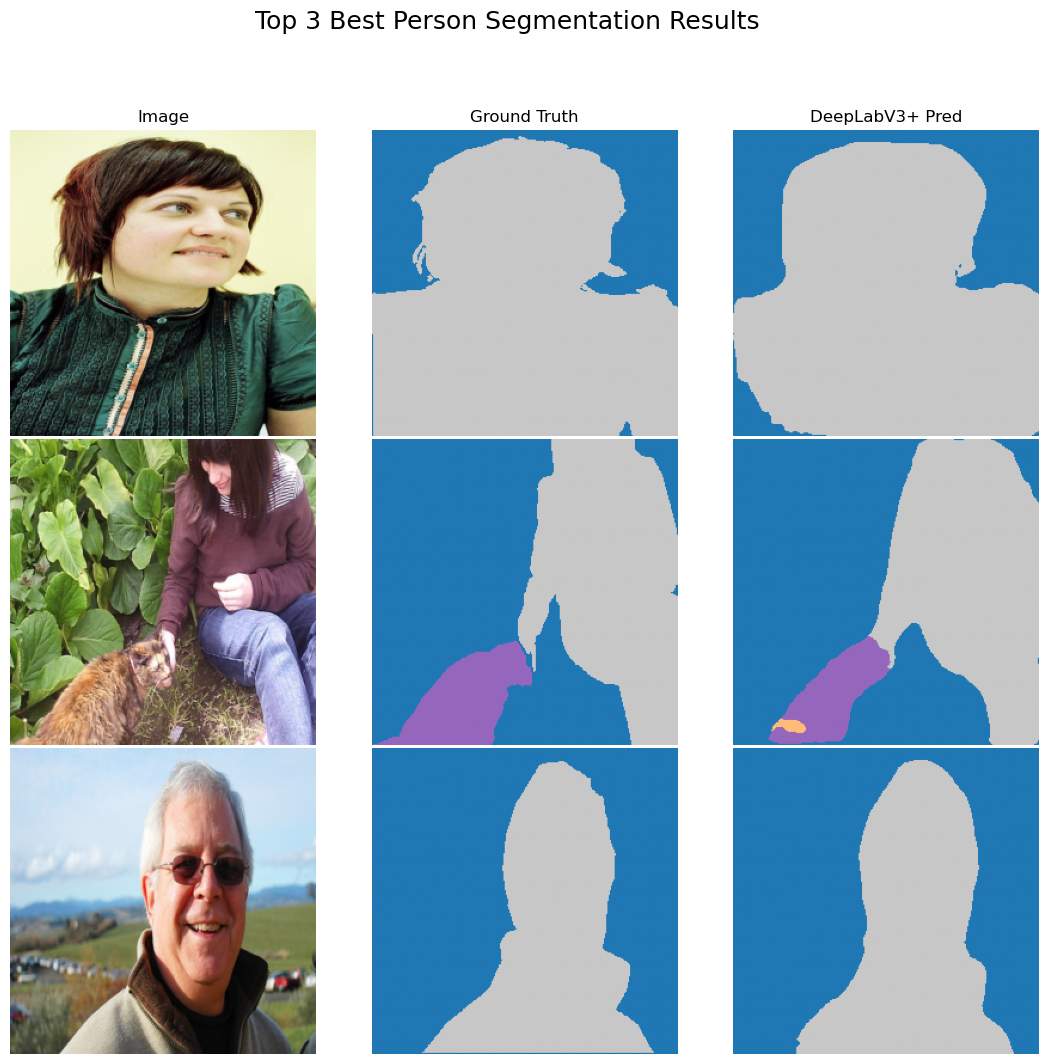

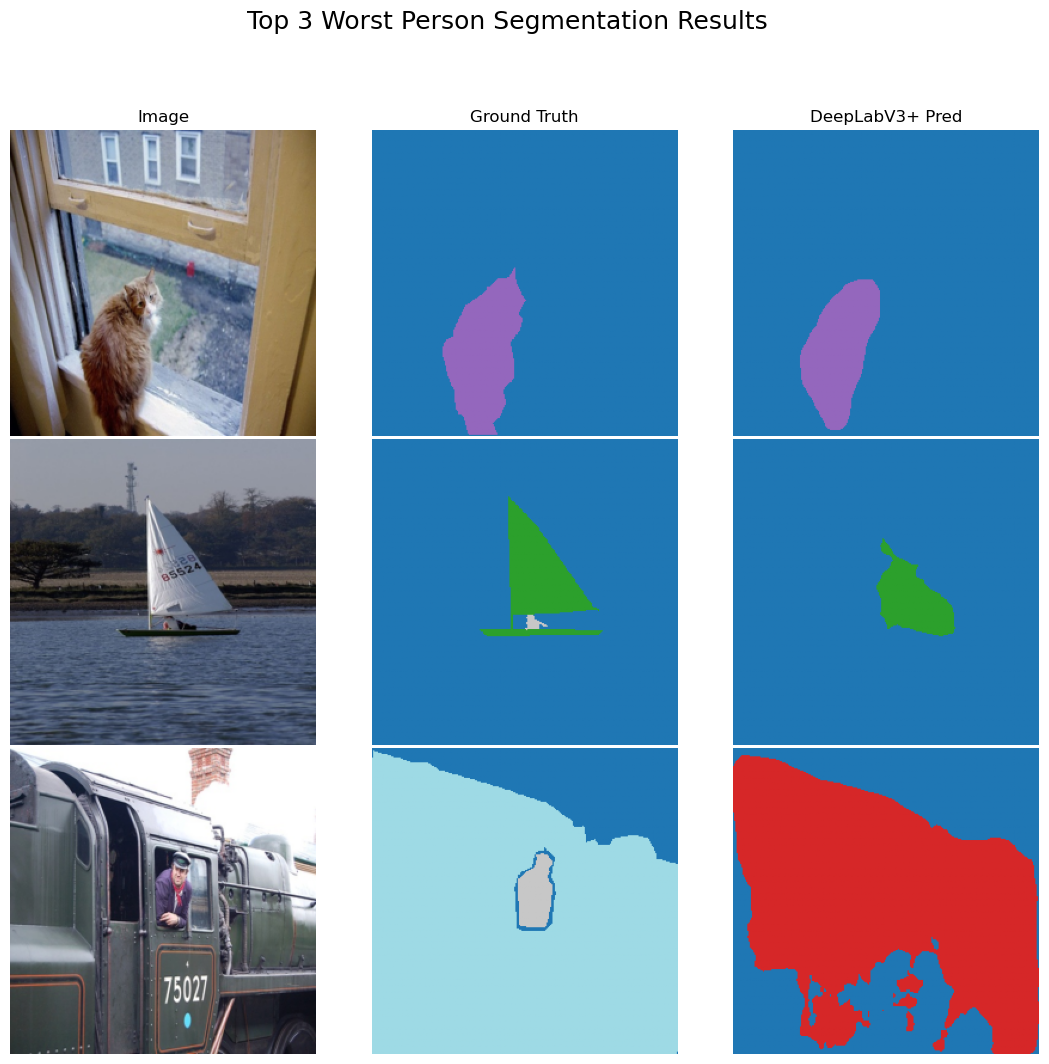

In [20]:
# get predictions for all test images
results = get_predictions(best_model, test_loader, device="cpu")

# rank by IoU(person)
best3, worst3 = rank_images_by_person(results)

print("Top 3 person IoUs:", best3)
print("Worst 3 person IoUs:", worst3)

# visualize
show_mosaic(results, best3, "Top 3 Best Person Segmentation Results")
show_mosaic(results, worst3, "Top 3 Worst Person Segmentation Results")